# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.animation as animation
from math import sqrt, log, cos, sin, pi
import math
import numpy as np
import os
import shutil
import re
from subprocess import call
import random
sb.set_style("whitegrid")
#sb.set_palette("cubehelix")
sb.set_palette("husl")
sb.set(font_scale=1) # crazy big
sb.set_style('whitegrid', {'legend.frameon':True})
myfontsize = 12
titlesize = 15
%matplotlib notebook

# Function to read the experiment settings file

In [2]:
# A function to return the default value if not any value is set
def value(row):
    if row["value"] != row["value"]: # not any new value
        return row["default"] # use of the default value
    else:
        return row["value"]

# read a csv type file with all the configurations/parameters/paths/...
def read_settings(filename="experiment_settings.csv", sep=";", subdir="generated_files"):
    df = pd.read_csv(filename, sep=sep)
    
    # open the subdirectory
    if not os.path.isdir(subdir):
        os.mkdir(subdir)
    
    # irace command line use
    dfcmd = df[df["use"] == "irace command line"]
    
    # irace path
    irace_path = value(dfcmd[dfcmd["name"] == "irace_path"].iloc[0])
    
    # scenario file path
    scenario_file = value(dfcmd[dfcmd["name"] == "scenario"].iloc[0])
        
    ###### generate scenario file
    f = open(subdir +  "/" + scenario_file, "w") # create a new scenario file in the sub directory
    dfscenario = df[df["use"] == "scenario file"]
    for index, row in dfscenario.iterrows():
        if row["type"] == "path":
            f.write(row["name"] + "=\"" + value(row) +"\"\n")
        else:
            f.write(row["name"] + "= " + value(row) +"\n")
        if row["name"] == "parameterFile": # parameter file path
            parameters_file = value(row)
        elif row["name"] == "trainInstancesFile": # instance file path
            instances_file = value(row)
        elif row["name"] == "targetRunner": # target runner file path
            target_runner_file = value(row)
        elif row["name"] == "configurationsFile": # initial configurations file path
            configurations_file = value(row)
        elif row["name"] == "forbiddenFile": # forbidden configuration rules file path
            forbidden_file = value(row)
        
    f.close()
    ######
    
    ###### copy instance file
    shutil.copyfile(instances_file, subdir + "/" + instances_file)
    
    ###### copy initial configurations file
    shutil.copyfile(configurations_file, subdir + "/" + configurations_file)
    ######
    
    ###### copy forbidden configurations rules file
    shutil.copyfile(forbidden_file, subdir + "/" + forbidden_file)
    ######
    
    ###### copy forbidden configuration rules file
    shutil.copyfile(forbidden_file, subdir + "/" + forbidden_file)
    
    ###### generate parameters file
    f = open(subdir +  "/" + parameters_file, "w") # create a new parameters file in the sub directory
    dfparameters = df[df["use"] == "parameter file"]
    dfparameters = dfparameters[~dfparameters["value"].isnull()] # used by irace only if there is a value is set
    
    ###########################################################################
    # a parameters file is defined by a table with 4 column and one row per parameter
    # name                switch                type                values
    # categorialparam     "--categorial-param"   c                  (1st value, 2nd value, ..., last value)
    # integerparam        "--integer-param"      i                  (min possible value, max possible value)
    # realparam           "--real-param"         r                  (min possible value, max possible value)
    ###########################################################################
    f.write("# name\tswitch\ttype\tvalues\t[condition]\n") # head of the param file
    
    for index, row in dfparameters.iterrows():
        ### several identical parameters ###
        # *<type><definition type>: set of parameters defined by its cardinal
        # become in irace:
        # myparam_1       "--myparam_1"    <type>        <definition type>        <| conditions>
        ####################################
        conditions = "| " + row["condition"]
        if re.search("\*", row["type"], flags=0): # a set of parameters is defined by * first character
            nb = int(row["value"]) # cardinal of the set
            for k in range(nb): 
                switch = row["name"] + "_" + str(k) + "="
                name = re.sub("-", "", row["name"]) + "_" + str(k) # irace doesn't support "-" in name
                paramtype = re.sub("\*", "", re.sub("\(.*\)","", row["type"]))
                values = re.sub("\*" + paramtype,"", row["type"])
                f.write(name + "\t\"" + switch + "\"\t" + paramtype[0] + "\t" + values + "\t" + conditions "\n")
        else: # a single parameter
            switch = row["name"] + "="
            name = re.sub("-", "_", row["name"]) # irace doesn't support "-" in name
            f.write(name + "\t\"" + switch + "\"\t" + row["type"][0] + "\t" + value(row) + "\t" + conditions + "\n")
    f.close()
    ######
    
    ###### generate the target runner file
    original_target_runer = open(target_runner_file, "r") # open target runner base
    f = open(subdir +  "/" + target_runner_file, "w") # create a new target runner file in the sub directory
    
    dftarget = df[df["use"] == "target runner file"]
    dftarget = dftarget[~dftarget["value"].isnull()] # modified only if there is a value is set

    for line in original_target_runer:
        changed = False
        for index, row in dftarget.iterrows():
            if re.search(row["name"] + " = .*", line, flags=0):
                f.write(row["name"] + " = " + row["value"] + "\n")
                changed = True
        if not changed:
            for index, row in dfcmd.iterrows():
                if re.search(row["name"] + " = .*", line, flags=0):
                    f.write(row["name"] + " = " + row["value"] + "\n")
                    changed = True
        if not changed:
            f.write(line)
    original_target_runer.close()
    f.close()
    
    # give execution rights to target runner file
    call(["chmod", "u+x", subdir +  "/" + target_runner_file])
    
    #print(subdir)
    # run irace for
    cmd = [irace_path, "--scenario", subdir + "/" + scenario_file]#, "--log-file", "iracelog.txt"]
    #print(cmd)
    call(cmd)
    #print("done")
    
    return df

SyntaxError: invalid syntax (<ipython-input-2-a3ec0627675f>, line 89)

# Functions for discrete distribution

In [ ]:
def uniform(n, digit=2):
    X = []
    for i in range(n):
        X.append(round(1/n, digit))
    return X

def logarithm(n, digit=2):
    X = []
    for i in range(n):
        X.append(round(2**(n-1-i)/(2**(n)-1), digit))
    return X

def binomial(n, digit=2, p=0.5):
    X = []
    for i in range(1,n+1):
        X.append(round(math.comb(n, i)*p**(i)*(1-p)**(n-i), digit))
    return X

def exponential(n, digit=2):
    return logarithm(n, digit=digit)[::-1]

def centered(n, digit=2):
    X = []
    if n%2 == 0:
        total = (n//2)**2 + n//2
        for i in range(n//2):
            X.append(round((i+1)/total, digit))
        for i in range(n//2,n):
            X.append(round((n-i)/total, digit))
    else:
        total = (n//2)**2 + n//2 + n//2 + 1
        for i in range(n//2):
            X.append(round((i+1)/total, digit))
        X.append(round((n//2 + 1)/total, digit))
        for i in range(n//2+1,n):
            X.append(round((n-i)/total, digit))
    return X

def camel(n, digit=2):
    X = []
    if n%2 == 0:
        X = centered(n//2, digit=digit)
        X += centered(n//2, digit=digit)
        for i in range(n):
            X[i] /= 2
    else:
        X = centered(n//2, digit=digit)
        X.append(0)
        X += centered(n//2, digit=digit)
        for i in range(n):
            X[i] /= 2
    return X

def unitary(n, digit=2):
    X = [1]
    for i in range(1,n):
        X.append(0)
    return X

def half(n, digit=2):
    X = []
    for i in range(n):
        X.append(0)
    if n%2 == 0:
        X[n//2 - 1] = 1
    else:
        X[n//2] = 1
    return X

# Functions to write initial config file

In [ ]:
def head_init_config(n):
    line = ""
    for i in range(n):
        line += "\tprob_" + str(i)
    line += "\n"
    return line

def convert_to_config(X):
    line = ""
    for x in X:
        line += "\t" + str(x)
    line += "\n"
    return line

# Functions to visualize custom law

In [3]:
def visuaze_custom_law(probs, sizes, colo ="blue", label=""):
    X = [0,0]
    for s in sizes:
        x = X[-1] + s
        X.append(x)
        X.append(x)
    Y = [0]
    for p in probs:
        Y.append(p)
        Y.append(p)
    Y.append(0)
    plt.plot(X,Y, color=colo, label=label)
    
import matplotlib.animation as animation


def init():
    line.set_data([], [])
    return line,

def y_coordinates(df, i):
    row = df.loc[i]
    Y = []
    for k in range(len(row)):
        if ("prob_" + str(k) in row):
            Y.append(float(row["prob_" + str(k)]))
    return Y

def animate_uniform(i):
    probs = y_coordinates(dfelites, i)
    sizes = uniform(len(probs))
    row = dfelites.loc[i]
    visuaze_custom_law(probs, sizes, label=row[".ID."])
    #plt.cla()
    plt.axis([0, 1, 0, 1])
    plt.gca().relim()
    plt.legend()
    
def animate_exponential(i):
    probs = y_coordinates(dfelites, i)
    sizes = exponential(len(probs))
    row = dfelites.loc[i]
    visuaze_custom_law(probs, sizes, label=row[".ID."])
    plt.cla()
    plt.axis([0, 1, 0, 1])
    probs = y_coordinates(dfelites, 0)
    sizes = exponential(len(probs))
    row = dfelites.loc[0]
    visuaze_custom_law(probs, sizes, colo="red", label=row[".ID."])
    
def folder_to_dict(folder):
    subfolder = re.sub(".*/", "", folder)
    slicing = re.sub("_s.*", "", subfolder)
    offspring_size = int(re.sub(".*_s.*_l", "", subfolder))
    size = int(re.sub(".*_s", "", re.sub("_l.*", "", subfolder)))
    mydict = {"slicing method":[slicing], "size":[size], "offspring-size":[offspring_size]}
    return mydict

def config_to_heatmap(df, filename):
    rowheat = {"offspring-size":[], "bucket":[], "prob":[]}
    dfheat = pd.DataFrame(rowheat)

    for index, row in df.iterrows():
        
        rowheat["offspring-size"] = row["offspring-size"]
        
        for k in range(len(row)) if ("prob_" + str(k) in row):
            rowheat["bucket"] = k
            rowheat["prob"] = row["prob_" + str(k)]
            dfheat = pd.concat([dfheat, pd.DataFrame(rowheat)])
            
    dfheat = dfheat.groupby(["offspring-size","bucket"], as_index=False).agg({"prob": 'mean'})       
    dfheat = dfheat.pivot("offspring-size", "bucket", "prob")
            
    figheat = plt.figure()
    sb.heatmap(dfheat, annot=True)
    figheat.savefig(filename)

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sb.heatmap(d, **kwargs)

SyntaxError: invalid syntax (<ipython-input-3-e4edefb74a8b>, line 67)

# Run script with experiment setting file

## number of parameter = bit string length

In [ ]:
for spm in ["uniform"]:
    for pb in range(19,20):
        for pbs in [32]:
            print("########## size: ", pbs, "##########")
            for pw2 in [1, 5, 10]:
                l = 2**pw2
                dfexp = pd.read_csv("experiment_settings.csv", sep=";")
                # change values corresponding to spm, pb, pbs, l in experiment_settings file
                dfexp.loc[dfexp["name"] == "prob",'value'] = pbs
                dfexp.loc[dfexp["name"] == "size_partition_method",'value'] = spm
                dfexp.loc[dfexp["name"] == "problem",'value'] = pb
                dfexp.loc[dfexp["name"] == "problem_size",'value'] = pbs
                dfexp.loc[dfexp["name"] == "offspring_size",'value'] = l
                dfexp.loc[dfexp["name"] == "max_evals",'value'] = pbs*50000*l
                
                # find the digit value
                dfdigit = dfexp[dfexp["name"] == "digits"]
                for index, row in dfdigit.iterrows():
                    print(value(row))
                    digit = int(value(row))
                
                # fill the initial configuration file
                dfpaths = dfexp[dfexp["type"] == "path"]
                for index, row in dfpaths.iterrows():
                    if row["name"] == "configurationsFile":
                        
                        f = open(value(row), "w") # modify the initial configurations file
                        f.write(head_init_config(pbs))
                        f.write(convert_to_config(binomial(pbs, digit)))
                        f.write(convert_to_config(binomial(pbs, digit)[::-1]))
                        f.write(convert_to_config(centered(pbs, digit)))
                        f.write(convert_to_config(camel(pbs, digit)))
                        f.write(convert_to_config(uniform(pbs, digit)))
                        f.close()

                folder_name = spm + '_s' + str(pbs) + "_l" + str(l)
                dfexp.to_csv(folder_name + ".csv", sep=";")
                print(folder_name)
                read_settings(filename=folder_name + ".csv", sep=";", subdir="results/" + folder_name)
                print("done")
                #os.remove(folder_name + ".csv")
                analysis_file = "analysis.R"
                call(["chmod", "u+x", analysis_file])
                shutil.copyfile(analysis_file, "results/" + folder_name + "/" + analysis_file)
                call(["chmod", "u+x", "results/" + folder_name +  "/" + analysis_file])
                call(["results/" + folder_name +  "/" + analysis_file, "results/" + folder_name, "irace.Rdata"])
                dfelites = pd.read_csv("results/" + folder_name + "/elites.csv", sep=",")
                fig = plt.figure()
                anim = animation.FuncAnimation(fig, animate, frames=len(dfelites), interval=1000)
                anim.save("results/" + folder_name + '/configurations.gif', writer='imagemagick')

In [32]:
import math

dim = 2

math.ceil(math.log(dim+1)/math.log(2))

2

## number of parameters is fixed

```
results_10                                                 # experiment results for 10 buckets
│   criterion.txt                                          # list of criterions
└───ECDF
│   └───eoCommaReplacement
│   │   │   slicing.txt                                    # list of buckets partitions
│   │   └───uniform
│   │   │   └───oneMax
│   │   │   │   └───10
│   │   │   │   │   └───1
│   │   │   │   │   │   │   analysis.R                     # R script to generates plots
│   │   │   │   │   │   │   elites.csv                     # dataframe of elites of each iteration
│   │   │   │   │   │   │   forbidden.txt                  # configurations constraints for irace
│   │   │   │   │   │   │   initial-config.txt             # initial configurations for irace
│   │   │   │   │   │   └───instance
│   │   │   │   │   │   │   │   oneMax_10.txt              # instance file for the genetic algorithm
│   │   │   │   │   │   │   │   ...
│   │   │   │   │   │   │   irace.Rdata                    # logs generated by irace
│   │   │   │   │   │   │   parameters.txt                 # parameters tunable by irace
│   │   │   │   │   │   └───plot
│   │   │   │   │   │   │   │   box_plot_test.pdf          # boxplot of elites on irace testing
│   │   │   │   │   │   │   │   configurations.gif         # probability law representation
│   │   │   │   │   │   │   │   convergence_plot.pdf       # convergences plot of elites on irace testing
│   │   │   │   │   │   │   │   frequency_plot.pdf         # frequency histogram on irace training
│   │   │   │   │   │   └───run
│   │   │   │   │   │   │   │   e_1_r_1.csv                # log dataframe of one elite run
│   │   │   │   │   │   │   │   ...
│   │   │   │   │   │   │   scenario.txt                   # settings for irace
│   │   │   │   │   │   │   target-runner.py               # script run by irace
│   │   │   │   │   │   ...
│   │   │   │   │   │   offspring.txt                      # list of offspring sizes
│   │   │   │   │   ...
│   │   │   │   │   size.txt                               # list of bitstring sizes
│   │   │   │   problem.txt
│   │   │   │   ...
│   │   │   ...
│   │   ...
│   ...
│   irace_elites.csv                                       # dataframe of elites configurations found by irace
```

In [270]:
def update_config(original_path, new_path, name_r, type_r, value_r="", argument_r="", probability_r=""):
    
    if not os.path.isdir(new_path):
        os.mkdir(new_path)
    
    dfconfig = pd.read_csv(original_path + "/config.csv", sep=";")
    new_row = pd.DataFrame({"name":[name_r],
                            "type":[type_r],
                            "value":[value_r],
                            "argument":[argument_r],
                            "probability":[probability_r]})
    dfconfig = pd.concat([dfconfig, new_row])
    dfconfig.to_csv(new_path + "/config.csv", sep=";", index = False)
    

In [276]:
nbparam = 10

execution_path = "../../release/onlymutga"

results_path = "results_fastGA_vs_onlymutGA"
if not os.path.isdir(results_path):
    os.mkdir(results_path)

update_config(".", results_path, name_r="GenContinuator", type_r="continuator", value_r="1000")

for criterion in ["NbG", "ECDF"]:
    
    criterion_path = results_path + "/" + criterion
    update_config(results_path, criterion_path, name_r=criterion, type_r="criterion") 
    
    for replacement in ["PlusReplacement", "CommaReplacement"]:

        replacement_path = criterion_path + "/" + replacement
        update_config(criterion_path, replacement_path, name_r=replacement, type_r="replacement", probability_r="1") 
    
        for problem in range(20):
                
            problem_path = replacement_path + "/" + str(problem)
            update_config(replacement_path, problem_path, name_r="instanceID", type_r="parameter", value_r=problem) 
                
            for pbs in [10, 100, 500]:
                 
                size_path = problem_path + "/" + str(pbs)
                update_config(problem_path, size_path, name_r="dimension", type_r="parameter", value_r=pbs) 
                    
                print("########## size: ", pbs, "##########")
                for l in range(1, 11):
                                                
                    offspring_path = size_path + "/" + str(l)
                    update_config(size_path, offspring_path, name_r="offspring_size", type_r="parameter", value_r=str(l)) 
                        
                    for slicing in ["uniform", "exponential"]:
            
                        slicing_path = replacement_path + "/" + slicing
                        if not os.path.isdir(slicing_path):
                            os.mkdir(slicing_path)

                            exe_path = "../" + execution_path

                            if slicing == "uniform":
                                animation_func = animate_uniform
                            elif slicing == "exponential":
                                animation_func = animate_exponential
                        plots_path = offspring_path + "/plots"
                        if not os.path.isdir(plots_path):
                            os.mkdir(plots_path)
                        
                        dfexp = pd.read_csv("default_settings.csv", sep=";")
                        # change values corresponding to spm, pb, pbs, l in experiment_settings file
                        #result/criterion/remplacement/slicing/problem/size/offspring
                        dfexp.loc[dfexp["name"] == "exe", 'value'] = "\"../../../../../../../../../release/onlymutga\""
                        dfexp.loc[dfexp["name"] == "prob",'value'] = nbparam
                        dfexp.loc[dfexp["name"] == "size_partition_method",'value'] = slicing
                        dfexp.loc[dfexp["name"] == "problem",'value'] = pb
                        dfexp.loc[dfexp["name"] == "problem_size",'value'] = pbs
                        dfexp.loc[dfexp["name"] == "offspring_size",'value'] = l
                        dfexp.loc[dfexp["name"] == "max_evals",'value'] = max(1000,10*pbs*l)
                        #dfexp.loc[dfexp["name"] == "replacement",'value'] = replacement
                        #dfexp.loc[dfexp["name"] == "criterion",'value'] = criterion

                        # find the digit value
                        dfdigit = dfexp[dfexp["name"] == "digits"]
                        for index, row in dfdigit.iterrows():
                            print(value(row))
                            digit = int(value(row))

                        # fill the initial configuration file
                        dfpaths = dfexp[dfexp["type"] == "path"]
                        for index, row in dfpaths.iterrows():
                            if row["name"] == "configurationsFile":

                                f = open(value(row), "w") # modify the initial configurations file
                                f.write(head_init_config(nbparam))
                                for p in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
                                    f.write(convert_to_config(binomial(nbparam, digit, p)))
                                f.write(convert_to_config(unitary(nbparam, digit)))
                                f.write(convert_to_config(centered(nbparam, digit)))
                                f.write(convert_to_config(uniform(nbparam, digit)))
                                f.write(convert_to_config(logarithm(nbparam, digit)))
                                f.close()

                        experiment_settings_file = offspring_path + "/experiment_settings.csv"
                        dfexp.to_csv("experiment_settings.csv", sep=";")
                        #shutil.copyfile(execution_path, experiment_settings_file)
                        shutil.copyfile(execution_path, offspring_path + "/onlymutga")
                        call(["chmod", "u+x", offspring_path + "/onlymutga"])

                        read_settings(filename="experiment_settings.csv", sep=";", subdir=offspring_path)
                        print("done")
                        #os.remove(folder_name + ".csv")
                        analysis_file = "analysis.R"
                        call(["chmod", "u+x", analysis_file])
                        shutil.copyfile(analysis_file, offspring_path + "/" + analysis_file)
                        call(["chmod", "u+x", offspring_path + "/" + analysis_file])
                        call([offspring_path + "/" + analysis_file, offspring_path, "irace.Rdata"])
                        dfelites = pd.read_csv(offspring_path + "/elites.csv", sep=",")
                        #fig = plt.figure()
                        #anim = animation.FuncAnimation(fig, animation_func, frames=len(dfelites), interval=1000)
                        #plt.legend()
                        #anim.save(plots_path + "/configurations.gif", writer='imagemagick')

FileNotFoundError: [Errno 2] No such file or directory: './config.csv'

<IPython.core.display.Javascript object>


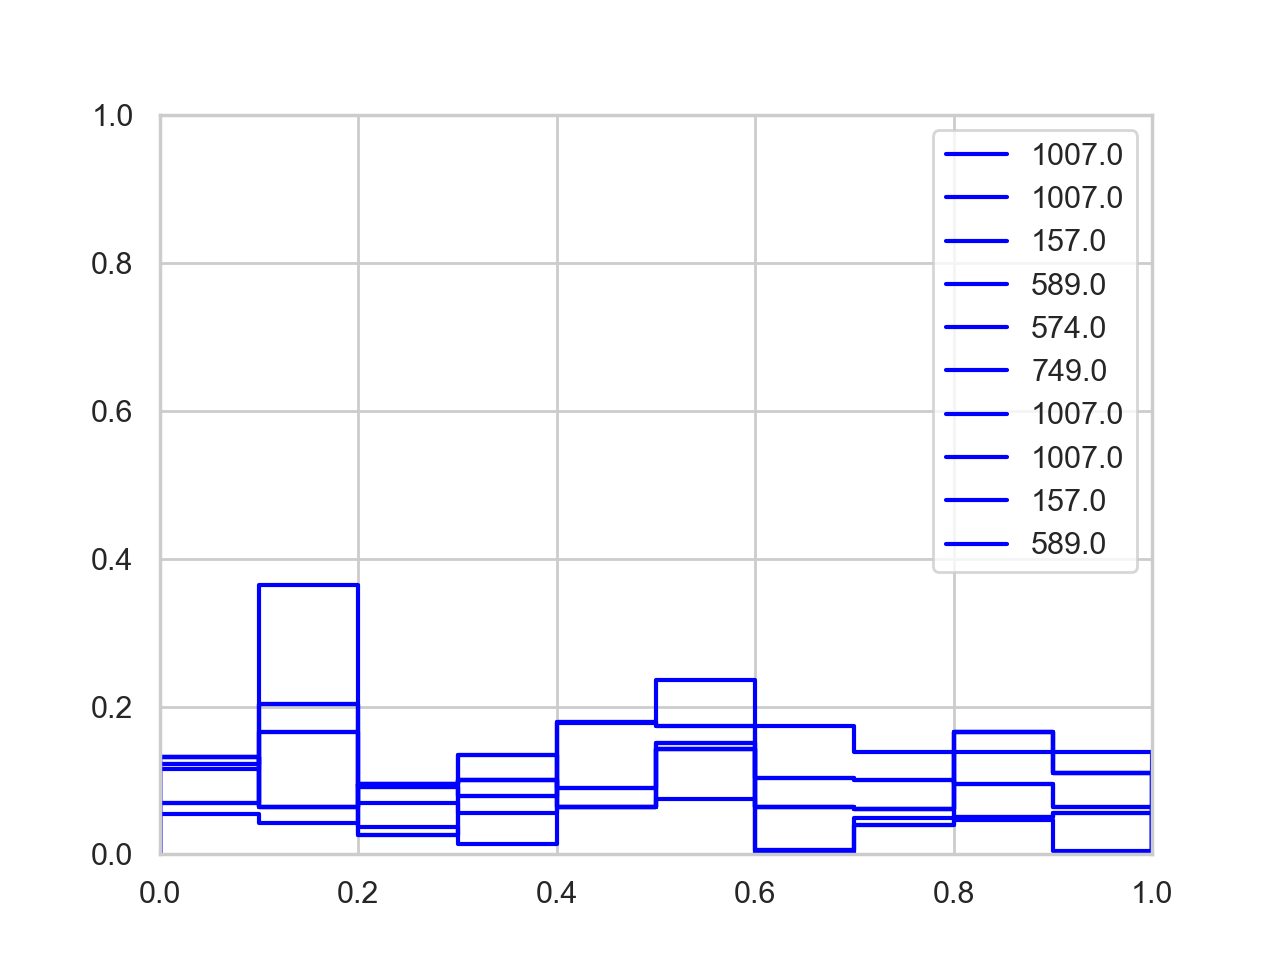

No handles with labels found to put in legend.
MovieWriter imagemagick unavailable; using Pillow instead.


In [240]:
label_colors = ["red", "orange", "green", "cyan", "blue", "purple", "black"]
slicing_dict = {"uniform":uniform,"exponential":exponential}
nbparam = 10
results_path = "results_" + str(nbparam)
for criterion_path in os.listdir(results_path) if os.path.isdir(os.path.join(results_path, criterion_path)):   
    
    columns = {"criterion":[], "slicing":[], "problem":[], "size":[], "offspring-size":[]}
    for p in range(nbparam):
        columns["prob_" + str(p)] = []
    dfrepconfig = pd.DataFrame(columns)
        
    for replacement_path in os.listdir(criterion_path) if os.path.isdir(os.path.join(criterion_path, replacement_path)):
        
        columns = {"slicing":[], "problem":[], "size":[], "offspring-size":[]}
        for p in range(nbparam):
            columns["prob_" + str(p)] = []
        dfsliceconfig = pd.DataFrame(columns)
            
        for slicing_path in os.listdir(replacement_path) if os.path.isdir(os.path.join(replacement_path, slicing_path)):
            
            slicing_method = slicing_dict[slicing_path.split("/")[-1]]
            columns = {"problem":[], "size":[], "offspring-size":[]}
            for p in range(nbparam):
                columns["prob_" + str(p)] = []
            dfprobconfig = pd.DataFrame(columns)
      
            for problem_path in os.listdir(slicing_path) if os.path.isdir(os.path.join(slicing_path, problem_path)):
                
                columns = {"size":[], "offspring-size":[]}
                for p in range(nbparam):
                    columns["prob_" + str(p)] = []
                dfsizeconfig = pd.DataFrame(columns)
                
                for size_path in os.listdir(problem_path) if os.path.isdir(os.path.join(problem_path, size_path)):
                    
                    dfpbheat = pd.DataFrame({"offspring-size":[], "bucket":[], "prob":[]})
                    columns = {"offspring-size":[]}
                    for p in range(nbparam):
                        columns["prob_" + str(p)] = []
                    dfoffconfig = pd.DataFrame(columns)
                    
                    for offspring_path in os.listdir(size_path) if os.path.isdir(os.path.join(size_path, offspring_path)):
                        if exists(offspring_path + "/elites.csv"):
                            
                            dfbest = pd.read_csv(folder + "/elites.csv", sep=",")
                            
                            configfig = plt.figure()
                            for index, row in dfbest.iterrows():
                                new_row = {"offspring-size":[offspring_path.split("/")[-1]]}
                                probs = []
                                for k in range(len(row)):
                                    if ("prob_" + str(k) in row):
                                        probs.append(float(row["prob_" + str(k)]))
                                        new_row["prob_" + str(k)] = [float(row["prob_" + str(k)])]
                                visuaze_custom_law(probs, slicing_method(len(probs)), colo = label_colors[index], label=row[".ID."])
                            configfig.savefig(offspring_path + "/plots/configurations.png")
                            dfoffconfig = pd.concat([dfconfig, new_row])
                            
                        dfoffconfig.to_csv(size_path + "offspring.csv", sep=";")
                        dfoffconfig["size"] = size_path.split("/")[-1]
                        dfsizeconfig = pd.concat([dfsizeconfig, dfconfig])
                
                    dfsizeconfig.to_csv(problem_path + "size.csv", sep=";")
                    dfsizeconfig["problem"] = problem_path.split("/")[-1]
                    dfprobconfig = pd.concat([dfprobconfig, dfsizeconfig])     
                
                dfprobconfig.to_csv(slicing_path + "problem.csv", sep=";")   
                dfprobconfig["slicing"] = slicing_path.split("/")[-1]
                dfsliceconfig = pd.concat([dfsliceconfig, dfprobconfig]) 
            
            dfsliceconfig.to_csv(replacement_path + "slicing.csv", sep=";")
            dfsliceconfig["replacement"] = replacement_path.split("/")[-1]
            dfrepconfig = pd.concat([dfrepconfig, dfsliceconfig])                       
    
        dfrepconfig.to_csv(criterion_path + "replacement.csv", sep=";")
        dfrepconfig["replacement"] = criterion_path.split("/")[-1]
        dfcritconfig = pd.concat([dfcritconfig, dfrepconfig])

    dfcritconfig.to_csv(results_path + "criterion.csv", sep=";")

    
fig = plt.figure()
anim = animation.FuncAnimation(fig, animate_uniform, frames=len(dfelites), interval=1000)
plt.legend()
anim.save(plots_path + "/configurations.gif", writer='imagemagick')

<IPython.core.display.Javascript object>


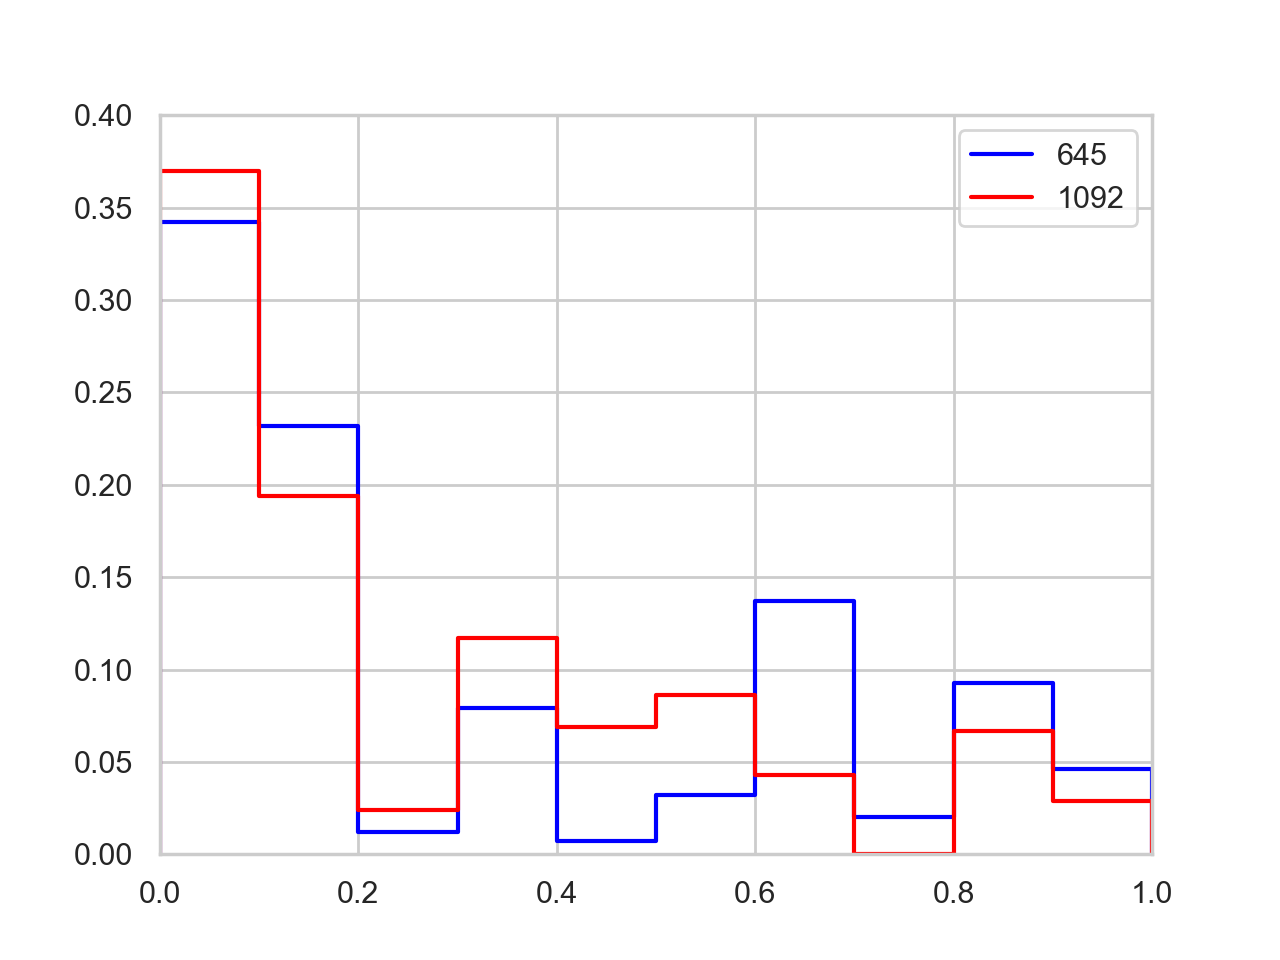

MovieWriter imagemagick unavailable; using Pillow instead.


In [11]:
dfelites = pd.read_csv("results_" + str(nbparam) + "/" + folder_name + "/elites.csv", sep=",")
fig = plt.figure()
anim = animation.FuncAnimation(fig, animate2, frames=len(dfelites), interval=1000)
anim.save("results_" + str(nbparam) + "/" + folder_name + '/configurations.gif', writer='imagemagick')

In [ ]:
                for index, row in dfpaths.iterrows():
                    if row["name"] == "configurationsFile":
                        
                        f = open(value(row), "w") # modify the initial configurations file
                        f.write(head_init_config(pbs))
                        f.write(convert_to_config(binomial(pbs, digit)))
                        f.write(convert_to_config(binomial(pbs, digit)[::-1]))
                        f.write(convert_to_config(centered(pbs, digit)))
                        f.write(convert_to_config(camel(pbs, digit)))
                        f.write(convert_to_config(uniform(pbs, digit)))
                        f.close()

In [ ]:
pbs = 32
l = 1024
for pbs in [8, 16, 32]:
    for l in [2, 32, 1024]:
        folder_name = "/Users/labeiros/Desktop/Postdoc/Work-code/paradiseo/eo/contrib/irace/expe/gamma/results/uniform_s" + str(pbs) + "_l" + str(l)
        ###### copy forbidden configurations rules file
        analysis_file = "analysis.R"
        shutil.copyfile(analysis_file, folder_name + "/" + analysis_file)
        # give execution rights to analisys script
        call(["chmod", "u+x", folder_name +  "/" + analysis_file])
        ######
        call([folder_name +  "/" + analysis_file, folder_name, "irace.Rdata"])
        dfelites = pd.read_csv(folder_name + "/elites.csv", sep=",")
        fig = plt.figure()
        anim = animation.FuncAnimation(fig, animate, frames=len(dfelites), interval=1000)
        anim.save(folder_name + '/configurations.gif', writer='imagemagick')
        dfelites

In [ ]:
fig = plt.figure()
visuaze_custom_law(unitary(16, digit=3), uniform(16, digit=3), colo="red")
visuaze_custom_law(binomial(16, digit=3), uniform(16, digit=3), colo="black")
visuaze_custom_law(uniform(16, digit=3), uniform(16, digit=3), colo="blue")
#visuaze_custom_law(binomial(32, digit=3)[::-1], uniform(32, digit=3), colo="red")
visuaze_custom_law(centered(16, digit=3), uniform(16, digit=3), colo="green")
#visuaze_custom_law(camel(32, digit=3), uniform(32, digit=3), colo="yellow")
plt.axis([0, 1, 0, 1])
fig.savefig('intial_config.png', bbox_inches='tight', dpi=150)
plt.show()

# Run a set of configurations

In [ ]:
import subprocess

def convert_to_string(vect):
    string = ""
    for v in vect:
        string += str(v) + ","
    return string[:-1]

def run_one_config(probs, sizes, instance, seed = 1000, problem = 19, problem_size = 8, pop_size = 1, offspring_size = 1, max_evals=1000, full_log=0):
    exe = os.path.expanduser("../../release/onlymutga")
    args = ["--problem=" + str(problem), 
            "--problem-size=" + str(problem_size), 
            "--crossover-rate=" + "0",
            "--mutation-rate=" + "1", 
            "--pop-size=" + str(pop_size), 
            "--offspring-size=" + str(offspring_size), 
            "--max-evals=" + str(max_evals), 
            "--instance=" + str(instance), 
            "--seed=" + str(seed)]
    
    args.append("--cl-probs=" + convert_to_string(probs))
    args.append("--cl-sizes=" + convert_to_string(sizes))
    
    cmd = [exe] + args
    #print(cmd)
    outf = open("output.txt", "a")
    errf = open("error_file.txt", "w")
    return_code = subprocess.call(cmd, stdout = outf, stderr = errf)
    outf.close()
    errf.close()

In [ ]:
outputfile = open("output.txt", "w")
outputfile.write("run;config;pop-size;offspring-size;instance;size;value\n")
outputfile.close()
for config, config_name in [(unitary, "unitary"), (uniform, "uniform"), (binomial, "binomial"), (centered, "centered"), (reverse_binomial, "reverse_binomial"), (camel, "camel")]:
    print("########################################", config_name, "########################################")
    for pbs in [8, 16, 32]:
        print("+++++++++++++++++ size:", pbs, "+++++++++++++++++")
        for l in [2, 32, 1024]:
            print("-------- lambda:", l, "--------")
            print(config(pbs, digit=3))
            for run in range(1,11):
                print(".... run:", run, "....")
                for instance in range(41):
                    #print("instance: ", instance)
                    outputfile = open("output.txt", "a")
                    outputfile.write(str(run) + ";" + 
                                     config_name + ";1;" + 
                                     str(l) + ";" + 
                                     str(instance) + ";" + 
                                     str(pbs) + ";")
                    outputfile.close()
                    
                    run_one_config(config(pbs, digit=3),uniform(pbs, digit=3), instance,  problem_size = pbs, offspring_size = l, max_evals = 10000*l, seed = run)
                    
                    

In [ ]:
#pbs=16
#run_one_config(config(pbs, digit=3),uniform(pbs, digit=3), instance, problem_size = pbs, offspring_size = l, max_evals = 10000*l, seed = run)

half(3)

In [ ]:
dfInitialsConfigResults = pd.read_csv("output.txt", sep=";")
g = sb.FacetGrid(dfInitialsConfigResults, col="size", row="offspring-size", height=5, aspect=1.5, sharey=False)
g.map(sb.violinplot, "config", "value", "config", palette="husl")
#for i, ax in enumerate(g.axes.flat): # set every-other axis for testing purposes
#    ax.legend(title="Config", facecolor ="white");
g.savefig("initials-confi-violinplot.png")

g = sb.FacetGrid(dfInitialsConfigResults, col="size", row="offspring-size", height=5, aspect=1.5, sharey=False)
g.map(sb.boxplot, "config", "value", "config", palette="husl")
#for i, ax in enumerate(g.axes.flat): # set every-other axis for testing purposes
#    ax.legend(title="Config", facecolor ="white");
g.savefig("initials-confi-boxplot.png")

In [ ]:
dftest = dfInitialsConfigResults.groupby(["config", "size", "offspring-size", "instance"], as_index=False).agg({"value":"mean"})
dftest

In [ ]:
newData = pd.merge(dftest, dftest.groupby(["instance","size","offspring-size"], as_index=False).agg({"value": "min"}), on=["instance", "size","offspring-size"])
newData.rename({'value_x': 'value', 'value_y': 'Best value'}, axis=1, inplace=True)
newData["Best"] = 0
newData.loc[newData['value'] == newData['Best value'], 'Best'] = 1
newData["Rank"] = newData.groupby(["instance","size", "offspring-size"], as_index=False)["value"].rank(ascending=1,method='min')
newData

In [ ]:
g = sb.FacetGrid(newData, row="offspring-size", col="size", hue="config", aspect=2, height=3, margin_titles=False)
g.map(sb.distplot, "Rank", bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], hist=True,norm_hist=True, kde=False)
for i, ax in enumerate(g.axes.flat): # set every-other axis for testing purposes
    ax.legend(title="Config", facecolor ="white");
g.savefig("initials-confi-rank-hist.png")

for s in set(newData["offspring-size"]):
    g = sb.FacetGrid(newData[newData["offspring-size"]==s], row="config", col="size", hue="config", aspect=2, height=3, margin_titles=False)
    g.map(sb.distplot, "Rank", bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], hist=True,norm_hist=True, kde=False)
    for i, ax in enumerate(g.axes.flat): # set every-other axis for testing purposes
        ax.legend(title="Config", facecolor ="white");
    g.savefig("initials-confi-rank-hist" + str(s) + ".png")

In [ ]:
pbs = 8
outputfile = open("output.txt", "w")
outputfile.write("run;config;pop-size;offspring-size;instance;size;value\n")
outputfile.close()
run_one_config(config(pbs, digit=3),uniform(pbs, digit=3), instance, max_evals = 5000, seed=random.randint(0,1000), full_log=0)

In [ ]:
1/35

In [ ]:
testvect = [0.062,0.062,0.062,0.062,0.062,0.062,0.062,0.062,0.062,0.062,0.062,0.062,0.062,0.062,0.062,0.062]
sum(testvect)

In [ ]:
X = []
n = 8
for i in range(n):
    X.append(round(1/n, digit))

sizes = ""
for i in range(len(X)):
    sizes += str(X[i])
    if i < len(X) - 1:
        sizes += ","
sizes

In [ ]:
prob1 = [0.561,0.964,0.934,0.301,0.928,0.328,0.734,0.733]
prob2 = [0.069,0.212,0.897,0.855,0.565,0.081,0.4,0.919]

sp1 = sum(prob1)
sp2 = sum(prob2)

for i in range(len(prob1)):
    prob1[i] /= sp1
    prob2[i] /= sp2

print(prob1)
print(prob2)

In [ ]:
fig = plt.figure()
visuaze_custom_law(prob1, uniform(8, digit=3), colo="black")
visuaze_custom_law(prob2, uniform(8, digit=3), colo="blue")
plt.show()

<IPython.core.display.Javascript object>


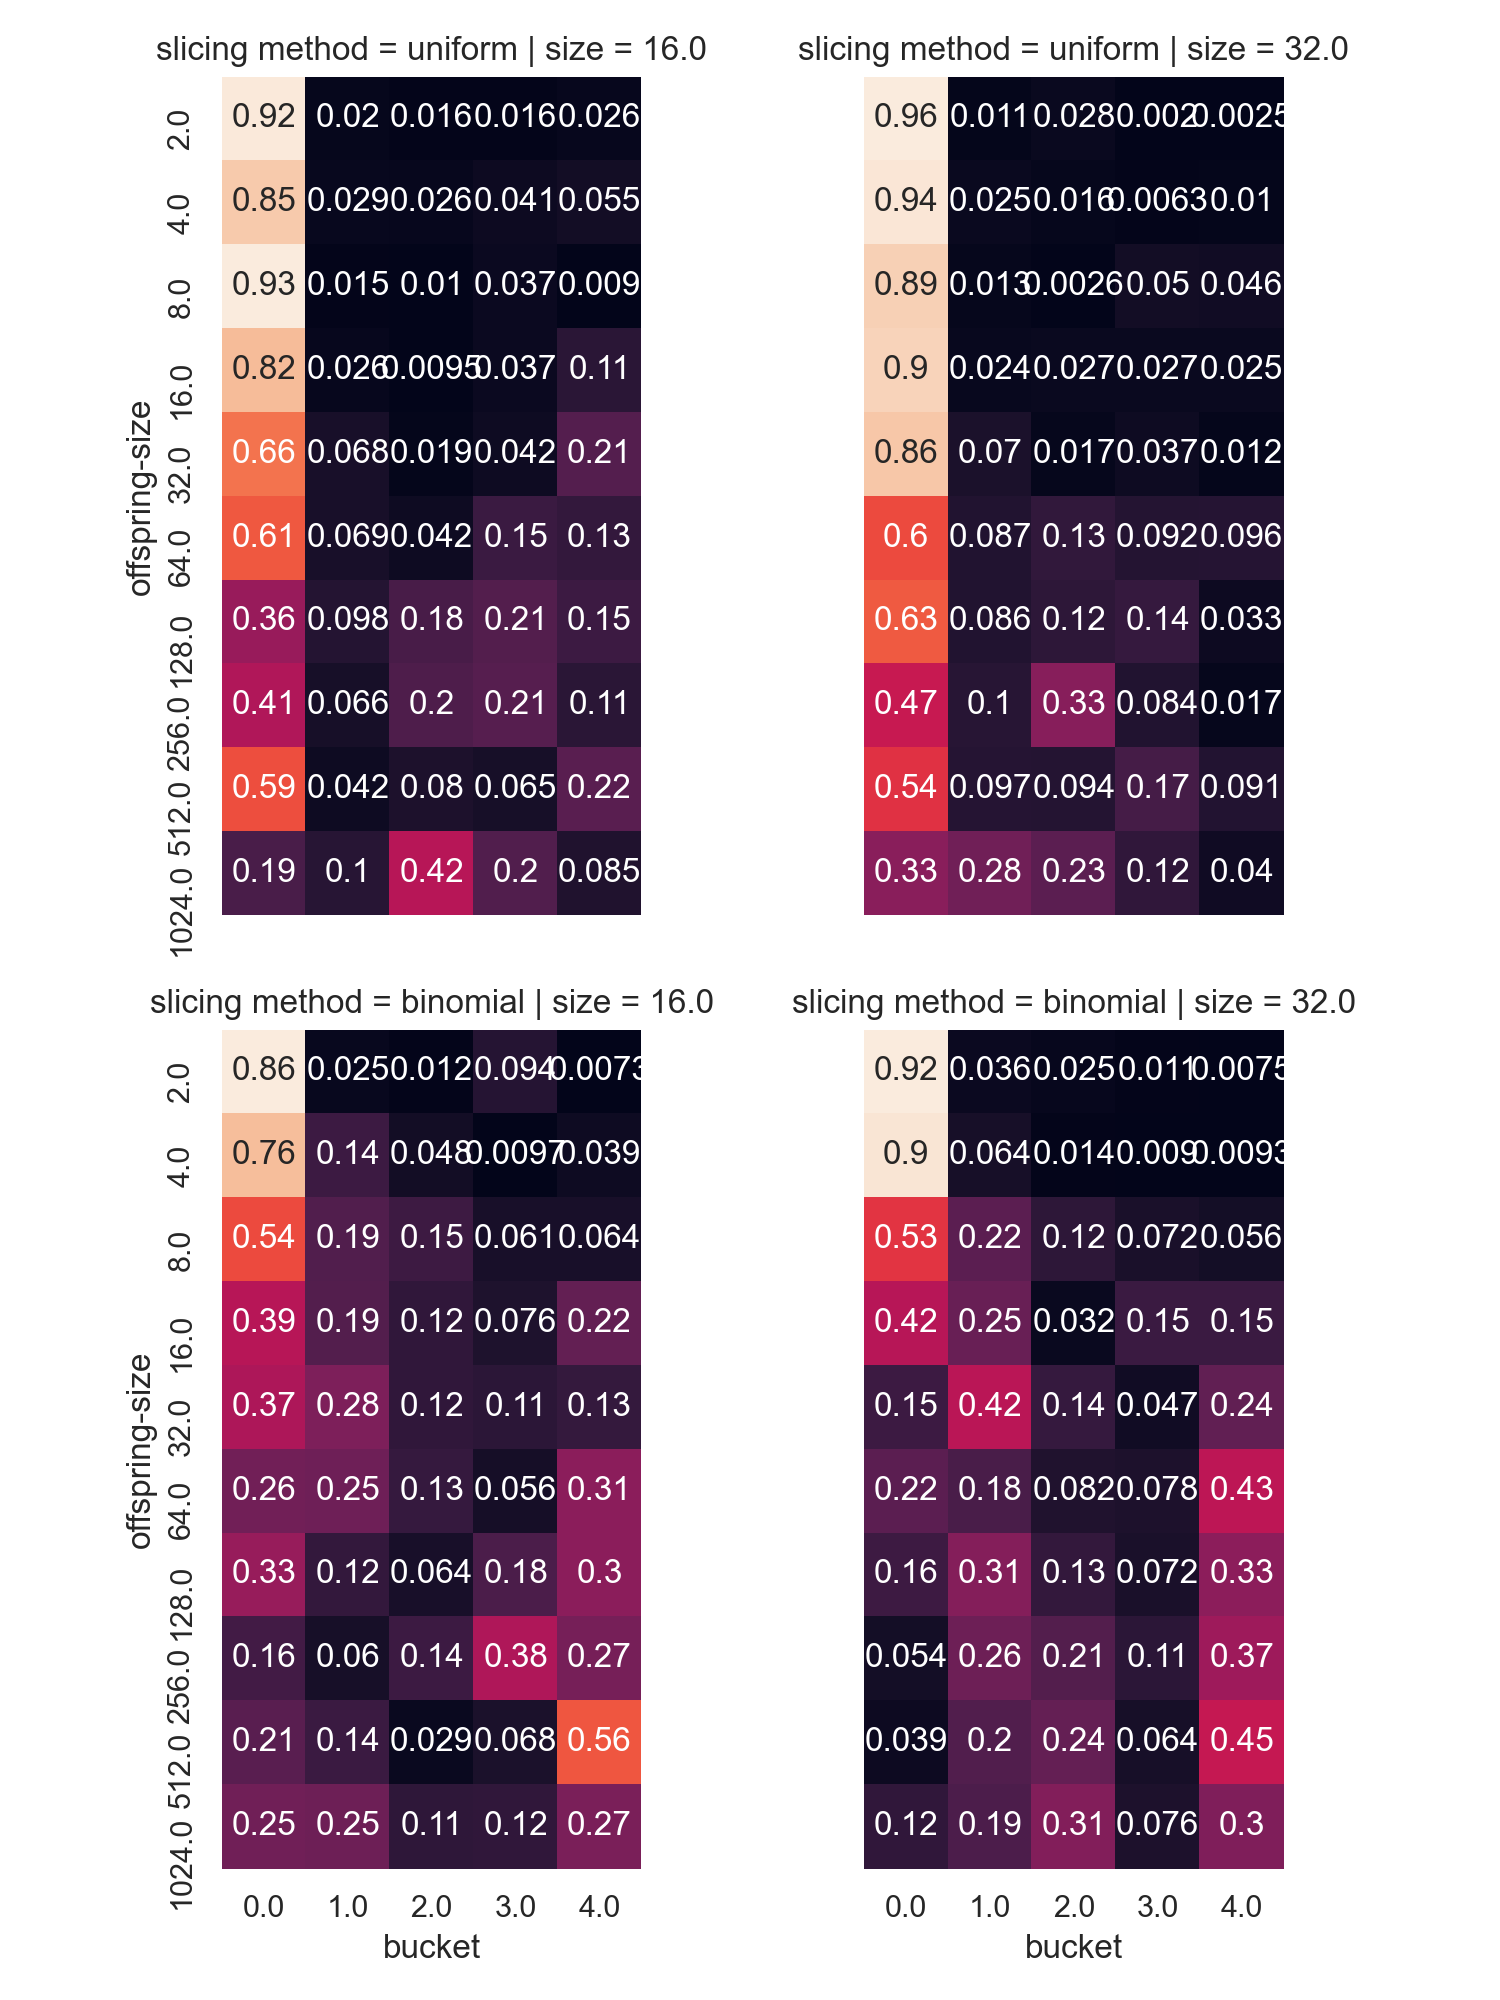

<IPython.core.display.Javascript object>


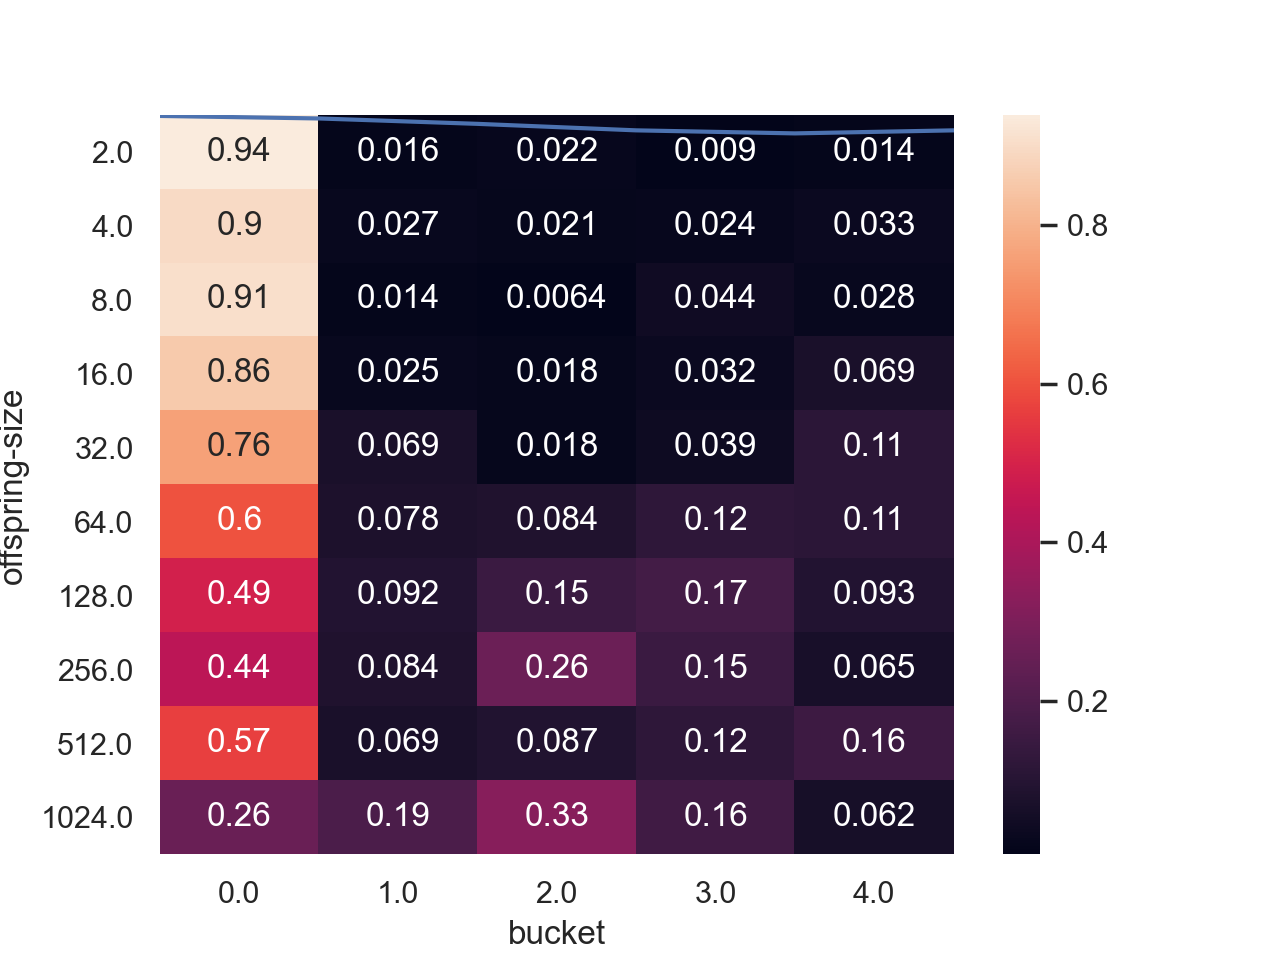

In [122]:
def folder_to_dict(folder):
    subfolder = re.sub(".*/", "", folder)
    slicing = re.sub("_s.*", "", subfolder)
    offspring_size = int(re.sub(".*_s.*_l", "", subfolder))
    size = int(re.sub(".*_s", "", re.sub("_l.*", "", subfolder)))
    mydict = {"slicing method":[slicing], "size":[size], "offspring-size":[offspring_size]}
    return mydict

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sb.heatmap(d, **kwargs)

nbparam = 5

columns = {"slicing method":[], "size":[], "offspring-size":[]}
cols = {"slicing method":[], "size":[], "offspring-size":[], "bucket":[], "prob":[]}
for p in range(nbparam):
    columns["prob_" + str(p)] = []
dfconfig = pd.DataFrame(columns)
dfheat = pd.DataFrame(cols)
subdir = "results_" + str(nbparam)
listfolder = [ subdir + "/" + name for name in os.listdir(subdir) if os.path.isdir(os.path.join(subdir, name)) ]
for folder in listfolder:
    dfbest = pd.read_csv(folder + "/elites.csv", sep=",")
    row = folder_to_dict(folder)
    rowheat = folder_to_dict(folder)
    for p in range(nbparam):
        row["prob_" + str(p)] = [dfbest.loc[0]["prob_" + str(p)]]
        rowheat["bucket"] = p
        rowheat["prob"] = dfbest["prob_" + str(p)].mean()
        #rowheat["prob"] = float(dfbest.loc[0]["prob_" + str(p)])
        dfheat = pd.concat([dfheat, pd.DataFrame(rowheat)])
    dfconfig = pd.concat([dfconfig, pd.DataFrame(row)], ignore_index=True)

dfheat = dfheat[dfheat["size"]<64]

fg = sb.FacetGrid(dfheat, col='size', row='slicing method', height=5, aspect=0.75)
fg.map_dataframe(draw_heatmap, "bucket", "offspring-size", "prob", cbar=False, square = True, annot=True)
# get figure background color
#facecolor=plt.gcf().get_facecolor()
fg.savefig("heatmap_test.png")
plt.show()
dfheat = dfheat[dfheat["slicing method"]=="uniform"]

dfheat = dfheat.groupby(["offspring-size","bucket"], as_index=False).agg({"prob": 'mean'})
#dfheat = dfheat[dfheat["size"]==16]
dfheat = dfheat.pivot("offspring-size", "bucket", "prob")
figheat = plt.figure()
sb.heatmap(dfheat, annot=True)
figheat.savefig("heatmap_" + str(nbparam) + ".png")
plt.show()


In [ ]:
dfconfig.pivot("month", "year", "passengers")

In [28]:
columns = {"slicing method":{}, "size":{}, "offspring-size":{}}
for p in range(10):
    columns["prob_" + str(p)] = {}
dfconfig = pd.DataFrame(columns)
dfconfig

,slicing method,size,offspring-size,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9


In [43]:
folder = "results_10/uniform_s16_l1024"
subfolder = re.sub(".*/", "", folder)
slicing = re.sub("_s.*", "", subfolder)
offspring_size = int(re.sub(".*_s.*_l", "", subfolder))
size = int(re.sub(".*_s", "", re.sub("_l.*", "", subfolder)))


16

In [62]:
flights = sb.load_dataset("flights")
flights
flights = flights.pivot("month", "year", "passengers")
#ax = sb.heatmap(flights)
flights

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
Jan,112,115,145,171,196,204,242,284,315,340,360,417
Feb,118,126,150,180,196,188,233,277,301,318,342,391
Mar,132,141,178,193,236,235,267,317,356,362,406,419
Apr,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
Jun,135,149,178,218,243,264,315,374,422,435,472,535
Jul,148,170,199,230,264,302,364,413,465,491,548,622
Aug,148,170,199,242,272,293,347,405,467,505,559,606
Sep,136,158,184,209,237,259,312,355,404,404,463,508


/opt/homebrew/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


<IPython.core.display.Javascript object>


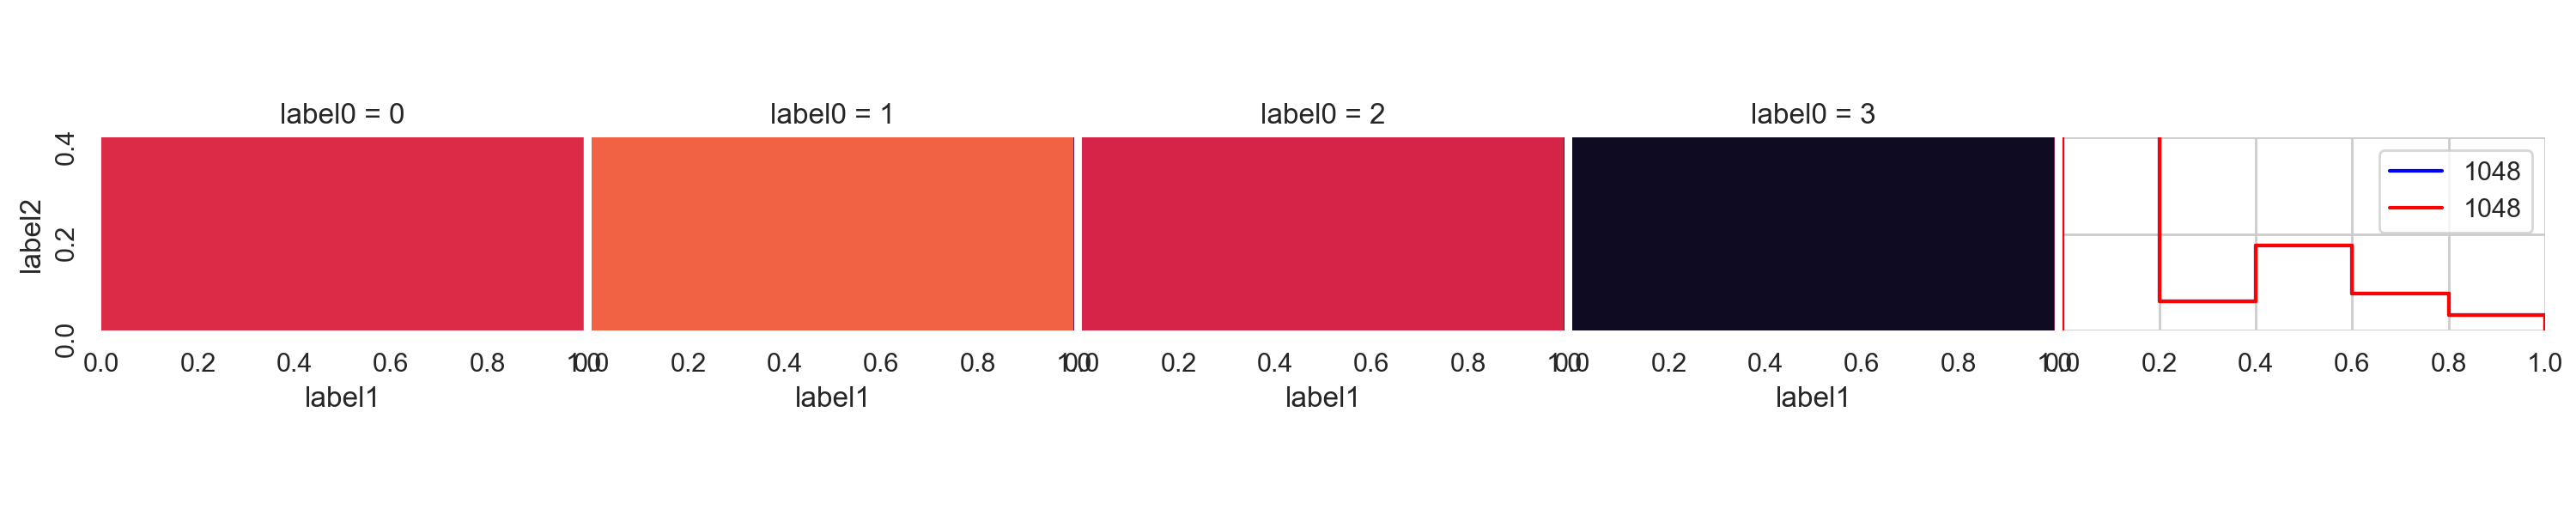

In [103]:
# Generate a set of sample data
np.random.seed(0)
indices = pd.MultiIndex.from_product((range(5), range(5), range(5)), names=('label0', 'label1', 'label2'))
data = pd.DataFrame(np.random.uniform(0, 100, size=len(indices)), index=indices, columns=('value',)).reset_index()

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sb.heatmap(d, **kwargs)

fg = sb.FacetGrid(data, col='label0')
fg.map_dataframe(draw_heatmap, 'label1', 'label2', 'value', cbar=False, square = True)
# get figure background color
#facecolor=plt.gcf().get_facecolor()
fg.savefig("heatmap_test.png")
plt.show()

<IPython.core.display.Javascript object>


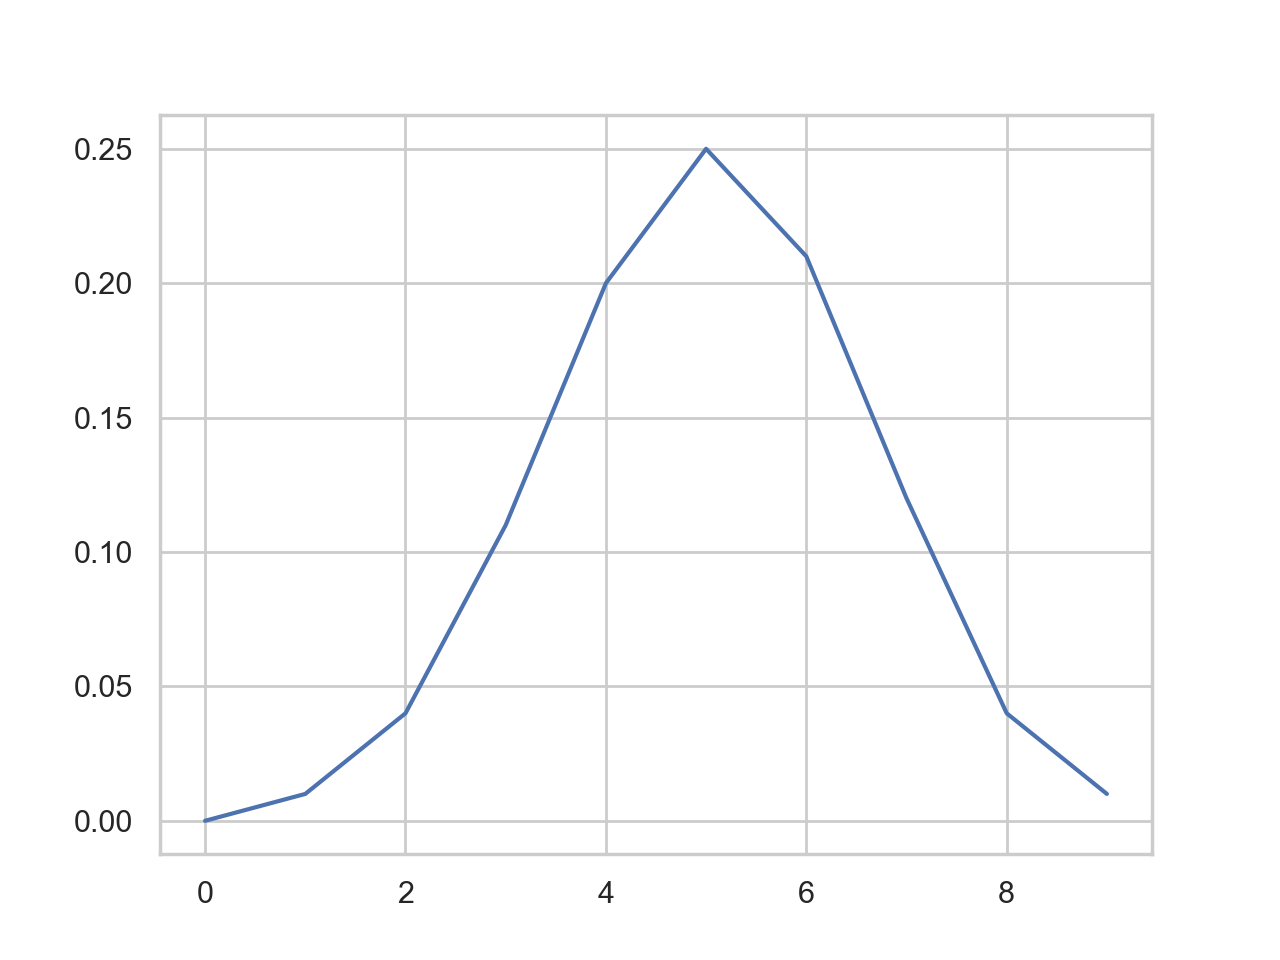

In [154]:
f = plt.figure()
plt.plot(binomial(10, digit=2, p=0.6))#, range(len(1,n+1)))
plt.show()

[0.01, 0.04, 0.12, 0.21, 0.25, 0.21, 0.12, 0.04, 0.01, 0.0]

In [162]:
"prob_10" in dfelites.loc[0]
print(len(dfelites.loc[0]))
dfelites.loc[0]

8


Unnamed: 0       1.000
.ID.          1105.000
prob_0           0.390
prob_1           0.242
prob_2           0.131
prob_3           0.233
prob_4           0.003
.PARENT.       809.000
Name: 0, dtype: float64

In [275]:
from manim import *

config.media_width = "60%"

%%manim -v WARNING -qm CircleToSquare

class CircleToSquare(Scene):
    def construct(self):
        blue_circle = Circle(color=BLUE, fill_opacity=0.5)
        green_square = Square(color=GREEN, fill_opacity=0.8)
        self.play(Create(blue_circle))
        self.wait()
        
        self.play(Transform(blue_circle, green_square))
        self.wait()

ModuleNotFoundError: No module named 'manim'